In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

In [13]:
df=pd.read_excel('../Hao_folder/samples_para_stress.xlsx')

In [14]:
df.columns

Index([     0.8806621611178381,       6.929460281685611,
             6.070214789084902,       5.090333131824253,
            1.9913069848705252,       5.955972360455448,
             5.801125666784954,      2.9238351824750968,
           0.18898669876261115,      1.5126641606671185,
            1.4572713593464723,     0.29564938827437465,
           0.21316954789073697, '0.21316954789073697.1',
            0.2402565869537286],
      dtype='object')

In [15]:
df.columns=['a','b','af','bf','as','bs','afs','bfs','gamma','sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']

In [16]:
df.describe()

,a,b,af,bf,as,bs,afs,bfs,gamma,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
count,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,5.025083,5.049962,5.049980,5.049999,5.025060,5.049981,5.024984,5.050042,0.250501,6.002989,6.002710,3.191936,2.817805,2.817805,3.191656
std,2.872315,2.857929,2.857938,2.857941,2.872343,2.857938,2.872373,2.857925,0.144052,7.699494,7.697265,4.702589,4.385529,4.385529,4.696326
min,0.050039,0.100056,0.100077,0.100021,0.050098,0.100143,0.050022,0.100049,0.001003,0.001304,0.001304,0.000158,0.000158,0.000158,0.000158
25%,2.537693,2.575004,2.574997,2.574997,2.537769,2.574972,2.537490,2.575016,0.125750,1.183854,1.183296,0.504343,0.421857,0.421857,0.507678
50%,5.025121,5.049846,5.049926,5.049907,5.025032,5.049972,5.024963,5.050184,0.250505,3.232980,3.233874,1.544447,1.297485,1.297485,1.543375
75%,7.512591,7.525040,7.525030,7.525009,7.512547,7.525016,7.512560,7.524976,0.375251,7.737697,7.734043,3.874724,3.299216,3.299216,3.879704
max,9.999967,9.999993,9.999902,9.999956,9.999914,9.999931,9.999929,9.999894,0.499993,84.196017,84.900921,52.826732,52.197974,52.197974,54.382342


In [17]:
df.head(5)

,a,b,af,bf,as,bs,afs,bfs,gamma,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
0,3.145409,1.666872,5.308194,7.532832,6.029283,0.435949,4.685014,6.931261,0.014293,0.112062,0.112066,0.045004,0.044973,0.044973,0.045008
1,5.928295,3.858229,7.181880,6.581534,5.270250,9.749043,1.044398,9.374484,0.300580,3.668962,3.567315,2.936709,2.525103,2.525103,2.835062
2,6.720615,2.550139,4.512333,7.554047,8.392858,9.420132,2.314248,0.447361,0.412720,6.103368,6.864435,5.072604,4.282678,4.282678,5.833670
3,7.667194,4.451551,4.247710,9.656474,7.709719,2.519522,0.545103,6.954437,0.331013,4.866012,5.096440,4.479420,4.133427,4.133427,4.709848
4,4.871057,2.721771,6.067258,7.333355,7.684224,1.565276,3.031701,3.486105,0.496787,10.623155,10.370392,7.062691,4.737183,4.737183,6.809928


In [10]:
feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()
Q = ['a','b','af','bf','as','bs','afs','bfs','gamma']

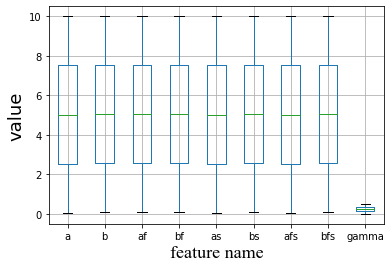

In [18]:
df[Q].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

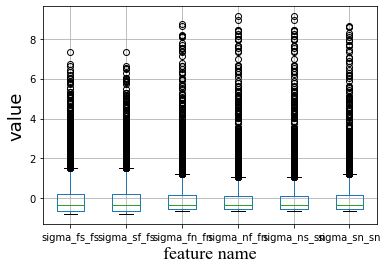

In [11]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [238]:
def box_plot_outliers(data_ser, box_scale):
    """
    remove some outliers
    :param data_ser: pandas.Series
    :param box_scale: the scale，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + 1.5*iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)
  

In [239]:
error_index = []
for col in feature_columns:
    error_index += box_plot_outliers(df[col],box_scale=1)

#df=df.drop(error_index)

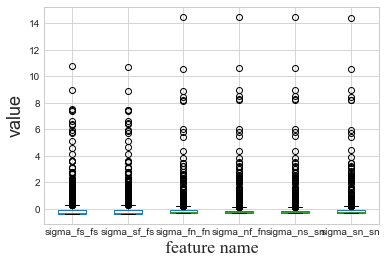

In [240]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [241]:
print(len(error_index))
data_ser = df[feature_columns[0]]
box_scale = -0.0019
iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
val_up = data_ser.quantile(0.75) + 1.5*iqr

print(val_up)


732
0.3232561595385781


In [242]:
q_data,y_data=df.iloc[:,0:9],df.iloc[:,9]


###################################
print(q_data,y_data)

            a          b        af         bf        as         bs       afs  \
0    2.508497   5.591436  1.046348  16.572831  2.024843  16.429041  6.570892   
1    1.939195  16.922009  1.028001   3.286520  9.715426  15.650890  6.993064   
2    7.967943   2.571042  8.998735   7.559782  2.191194   4.473826  3.193243   
3    5.475308  16.789631  6.349736   7.223862  0.397983   8.038741  4.969531   
4    2.615082  12.229693  6.530510  13.339543  5.737378   9.032523  4.345270   
..        ...        ...       ...        ...       ...        ...       ...   
994  7.165104   9.005023  5.855529  10.834621  6.435474   2.434221  4.634764   
995  7.814740   2.461724  0.692261  15.672442  2.751700  10.077316  8.780820   
996  4.587391   4.447096  5.145266   6.630154  5.059356  10.045190  2.924833   
997  9.194355   1.744849  7.170330   1.923715  6.231396  15.430998  2.881604   
998  4.854931  16.524555  8.163320  18.080850  1.505479  12.718577  9.136197   

           bfs     gamma  
0     3.3247

In [243]:
train_size=int(0.9*len(q_data))

In [244]:
q_data_train,q_data_test=q_data.iloc[:train_size],q_data.iloc[train_size:]
y_data_train,y_data_test=y_data.iloc[:train_size],y_data.iloc[train_size:]

In [245]:
print(q_data_train)
print(y_data_train)

            a          b        af         bf        as         bs       afs  \
0    2.508497   5.591436  1.046348  16.572831  2.024843  16.429041  6.570892   
1    1.939195  16.922009  1.028001   3.286520  9.715426  15.650890  6.993064   
2    7.967943   2.571042  8.998735   7.559782  2.191194   4.473826  3.193243   
3    5.475308  16.789631  6.349736   7.223862  0.397983   8.038741  4.969531   
4    2.615082  12.229693  6.530510  13.339543  5.737378   9.032523  4.345270   
..        ...        ...       ...        ...       ...        ...       ...   
894  2.339190  17.530310  2.716799   9.591934  0.411964  19.671394  7.965503   
895  7.336908   6.435556  0.825912  19.713119  3.597101  14.107180  7.033201   
896  3.760828   4.749257  5.257669   1.581095  0.451794  15.141682  9.206191   
897  8.943941  17.259570  9.021675   7.777624  9.254779   8.442607  1.552470   
898  8.885759  14.393820  8.927806  14.910504  1.942070   9.752247  9.944017   

           bfs     gamma  
0     3.3247

In [246]:
print(q_data_test)

            a          b        af         bf        as         bs       afs  \
899  1.111241   4.257931  5.791014   2.638933  2.575946   9.877654  8.934160   
900  9.399138   2.868225  7.650930   1.164899  0.294300   2.997086  1.768083   
901  4.530584   5.414663  0.393702  14.037499  3.131102  18.980338  5.026663   
902  2.811353   2.232175  6.452803   6.352430  6.000137  14.749413  1.105079   
903  8.601744   8.872191  3.975671  11.778214  0.856107   5.686224  3.879342   
..        ...        ...       ...        ...       ...        ...       ...   
994  7.165104   9.005023  5.855529  10.834621  6.435474   2.434221  4.634764   
995  7.814740   2.461724  0.692261  15.672442  2.751700  10.077316  8.780820   
996  4.587391   4.447096  5.145266   6.630154  5.059356  10.045190  2.924833   
997  9.194355   1.744849  7.170330   1.923715  6.231396  15.430998  2.881604   
998  4.854931  16.524555  8.163320  18.080850  1.505479  12.718577  9.136197   

           bfs     gamma  
899   4.1133

In [247]:
#q_data_exp,y_data_exp=q_data.iloc[-1,:].values.reshape((1,-1)),y_data.iloc[-1,:].values.reshape((1,-1))
#print(y_data_exp)

In [248]:
q_data_train.shape,q_data_test.shape

((899, 9), (100, 9))

In [249]:
#q_data_exp

In [250]:
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [251]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [252]:
X.shape,y.shape,X_test.shape,y_test.shape

((899, 9), (899,), (100, 9), (100,))

In [253]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [263]:
## not yet finished
kernel = RBF(length_scale= 1, length_scale_bounds=(0.0,100))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(1):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y)
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)

fitting feature 0
RBF(length_scale=0.578)


In [264]:
# predicting the output and others using the selected hyperparameters
feat_flag = 0
print('fitting feature %d' % feat_flag)
gpr_sub = gpr_models[feat_flag]
pred = gpr_sub.predict(X)
print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y, pred),metrics.r2_score(y, pred)))

fitting feature 0
gpr Test: mse loss=0.000000 r2_score=1.000000


Text(0.5, 1.0, 'feature 1')

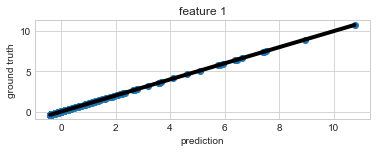

In [260]:
plt.style.use('seaborn-whitegrid')
plt.subplot(2,1,1)
feat_flag = 0;
feature_min = min(pred)
feature_max = max(pred)
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(pred, y, marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

In [267]:

for feat_flag in range(1):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    y_pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test, y_pred),metrics.r2_score(y_test, y_pred)))


fitting feature 0
gpr Test: mse loss=0.352816 r2_score=-0.026813


Text(0.5, 1.0, 'feature 1')

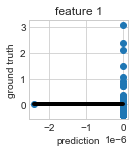

In [268]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred)
feature_max = max(y_pred)
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred, y_test, marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()



In [213]:
from xgboost import XGBRegressor

In [214]:
xgboost_params = []
grid_params = {
            'n_estimators' : [500, 1000, 2000],
            'max_depth' : [1, 2, 4, 6, 8, 16],
            'learning_rate' : [0.05, 0.1, 0.2],
            'objective' : ['reg:squarederror'],
            'booster' : ['gbtree'],
            'n_jobs' : [-1]
   }
xgboost_sub = GridSearchCV(XGBRegressor(), grid_params, scoring = 'r2', n_jobs = 1, cv = 2)

In [215]:
xgboost_sub.fit(q_data, y_data)
#print(xgboost_sub.best_params_)
#xgboost_params.append(xgboost_sub.best_params_)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [216]:
print(xgboost_sub.best_params_) 
xgboost_params.append(xgboost_sub.best_params_)

{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squarederror'}


In [217]:
xgboost_sub = XGBRegressor(**xgboost_params[0])
xgboost_sub.fit(X, y)
pred = xgboost_sub.predict(X_test)
print('XGBoost Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test, pred),metrics.r2_score(y_test, pred)))

XGBoost Test: mse loss=0.001744 r2_score=0.894900


Text(0.5, 1.0, 'feature 1')

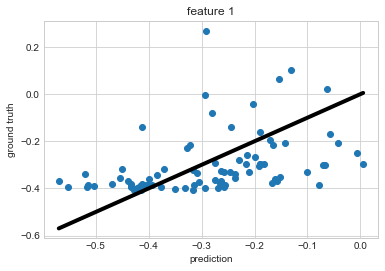

In [218]:
plt.style.use('seaborn-whitegrid')
plt.subplot(1,1,1)
feature_min = min(y_pred)
feature_max = max(y_pred)
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred, y_test, marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')